In [1]:
import numpy as np
import pandas as p
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import scipy
from scipy import stats
# from adjustText import adjust_text
from Bio import SeqIO
from Bio.Seq import Seq
%matplotlib inline

import copy



%load_ext autoreload
%autoreload 2


# import gzip
# from cyvcf2 import VCF

from matplotlib import gridspec
from matplotlib.gridspec import GridSpec

from itertools import combinations
from itertools import combinations_with_replacement
from itertools import permutations
from ast import literal_eval

import sys
import os

home_dir = '~/Documents/Stanford/Research/EvolvingFront/'
home_dir = os.path.expanduser(home_dir)

tools_path = f'{home_dir}/code/processing/tools/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools
import figures as figures





In [2]:
theme = 'dark'
# theme = 'dark'


if theme == 'light':

    sns.set_style('white')
    sns.set_style('ticks')
    sns.set_color_codes()
    
else:
    theme = 'dark'
    sns.set_style('dark')
    sns.set_style('ticks')
    plt.style.use('dark_background')
matplotlib.rcParams['font.family'] = 'Avenir'
# sns.set_context('default')

In [3]:
merged_fitness = p.read_csv(f'{home_dir}/data/fitness_withMutations.csv',index_col=0)
# noLi2019 = merged_fitness[merged_fitness['source_publication']!='Li2019']

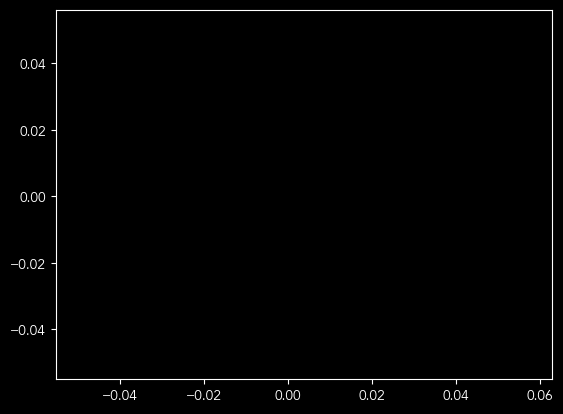

In [4]:
### Draw the old pareto front line from Li et al 2019
old_muts = merged_fitness[merged_fitness['source_publication'].isin(['Venkataram2015','Li2019'])]

points = old_muts[['FerPerHour_Li2019','ResPerHour_Li2019']].values
points = points[~np.isnan(points).any(axis=1)]

hull = scipy.spatial.ConvexHull(points)

pareto_line = (list(points[hull.vertices,0][5:-1])+[0],list(points[hull.vertices,1][5:-1])+[np.nanmax(old_muts['ResPerHour_Li2019'].values)])

### Draw a new "pareto" line using only 2day mutants from Levy et al  2015
levy2015 = merged_fitness[(merged_fitness['source_publication'].isin(['Venkataram2015'])) & 
                          (merged_fitness['evolution_condition'].isin(['Evo2D']))
                         ]
points = levy2015[['FerPerHour','ResPerHour']].values
points = points[~np.isnan(points).any(axis=1)]

hull = scipy.spatial.ConvexHull(points)

# pareto_line = (lis

# levy_pareto_line = (list(points[hull.vertices,0][1:5])+[0],
#                     list(points[hull.vertices,1][1:5])+[np.nanmax(levy2015['ResPerHour'].values)])
levy_pareto_line = ([np.nanmax(levy2015['FerPerHour'].values)]+list(points[hull.vertices,0][1:5])+[-0.05],
                    [-0.05]+list(points[hull.vertices,1][1:5])+[np.nanmax(levy2015['ResPerHour'].values)])

# plt.plot()
plt.plot(levy_pareto_line[0],levy_pareto_line[1], 'k--', lw=2)

# xdata = 'FerPerHour'
# ydata = 'ResPerHour'

# wt_data = levy2015[levy2015['class_new'].isin(['adaptive_haploid','high_fitness_diploids'])]
# sns.kdeplot(x=wt_data[xdata+'_relative'].values,y=wt_data[ydata+'_relative'].values,
#                                                     color='k',fill=True,thresh=0.1,levels=9,
#                                                     alpha=0.8,label=evo_cond,bw_method=0.4)
# plt.plot(points[hull.vertices[0],0], points[hull.vertices[0],1], 'ro')

In [5]:
def count_tradeoffs(data_x,data_y,
                    error_x,error_y,
                    background_data_x,background_data_y,
                    background_error_x,background_error_y,
                    multiplier=1.96,use_both_errors=False,use_standard_error=False):
    
    if use_standard_error == True:
        background_error_x = background_error_x/len(background_error_x)
        background_error_y = background_error_y/len(background_error_y)
    
    if not use_both_errors:
    
        x_improved = (data_x>(background_data_x+multiplier*background_error_x))
        y_improved = (data_y>(background_data_y+multiplier*background_error_y))

        x_reduced = (data_x<(background_data_x-multiplier*background_error_x))
        y_reduced = (data_y<(background_data_y-multiplier*background_error_y))

        x_same = np.logical_and(~x_reduced,~x_improved)
        y_same = np.logical_and(~y_reduced,~y_improved)

    #     both_improved = np.logical_and(x_improved,y_improved)


        improvement_matrix = [[np.logical_and(x_reduced,y_reduced),np.logical_and(x_reduced,y_same),np.logical_and(x_reduced,y_improved)],
                              [np.logical_and(x_same,y_reduced),np.logical_and(x_same,y_same),np.logical_and(x_same,y_improved)],
                              [np.logical_and(x_improved,y_reduced),np.logical_and(x_improved,y_same),np.logical_and(x_improved,y_improved)]
                             ]

        both_indices = np.where(improvement_matrix[2][2])[0]

        improvement_matrix = [[np.sum(improvement_matrix[x][y]) for y in range(3)] for x in range(3)]
        
    else:
#         scipy.stats.ttest_ind_from_stats(data_x,error_x)
        
        
        x_improved = (data_x-multiplier*error_x>(background_data_x))
        y_improved = (data_y-multiplier*error_y>(background_data_y))
#                     reduced = (data[:,f]+multiplier*error[:,f]<(background_data[f]))

        x_reduced = (data_x+multiplier*error_x<(background_data_x))
        y_reduced = (data_y+multiplier*error_y<(background_data_y))
#         y_reduced = (data_y<(background_data_y-multiplier*background_error_y))

        x_same = np.logical_and(~x_reduced,~x_improved)
        y_same = np.logical_and(~y_reduced,~y_improved)

    #     both_improved = np.logical_and(x_improved,y_improved)


        improvement_matrix = [[np.logical_and(x_reduced,y_reduced),np.logical_and(x_reduced,y_same),np.logical_and(x_reduced,y_improved)],
                              [np.logical_and(x_same,y_reduced),np.logical_and(x_same,y_same),np.logical_and(x_same,y_improved)],
                              [np.logical_and(x_improved,y_reduced),np.logical_and(x_improved,y_same),np.logical_and(x_improved,y_improved)]
                             ]

        both_indices = np.where(improvement_matrix[2][2])[0]

        improvement_matrix = [[np.sum(improvement_matrix[x][y]) for y in range(3)] for x in range(3)]
    
    
    return improvement_matrix,len(data_x),both_indices

In [6]:
def bootstrap_tradeoffs(data_x,data_y,
                    error_x,error_y,
                    background_data_x,background_data_y,
                    background_error_x,background_error_y,
                    multiplier=0,use_both_errors=False,use_standard_error=False,n_resamples=100):
    
    resampling_matrix = np.zeros((n_resamples,3,3))
    
    for resampling in range(n_resamples):
        resampled_x = np.random.normal(data_x,error_x)
        resampled_y = np.random.normal(data_y,error_y)

        

        improvement_matrix,n_obs,both_indices = count_tradeoffs(resampled_x,resampled_y,
                                                                error_x,error_y,
                                                                background_data_x,background_data_y,
                                                                background_error_x,background_error_y,
                                                                multiplier=0,use_both_errors=True
                                                               )
#         print(np.asarray(improvement_matrix).shape)
        resampling_matrix[resampling,:,:] = np.asarray(improvement_matrix)/n_obs
  
    
    mean_matrix = np.mean(resampling_matrix,axis=0)
    std_matrix = np.std(resampling_matrix,axis=0)
    
    return mean_matrix,std_matrix
    

/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_23454/1673457357.py:22: RuntimeWarning: invalid value encountered in divide
  resampling_matrix[resampling,:,:] = np.asarray(improvement_matrix)/n_obs
/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_23454/1673457357.py:22: RuntimeWarning: invalid value encountered in divide
  resampling_matrix[resampling,:,:] = np.asarray(improvement_matrix)/n_obs
/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_23454/1673457357.py:22: RuntimeWarning: invalid value encountered in divide
  resampling_matrix[resampling,:,:] = np.asarray(improvement_matrix)/n_obs
/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_23454/1673457357.py:22: RuntimeWarning: invalid value encountered in divide
  resampling_matrix[resampling,:,:] = np.asarray(improvement_matrix)/n_obs
/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_23454/1673457357.py:22: RuntimeWarning: invalid value encountered in divide
  resampling_matrix[resam

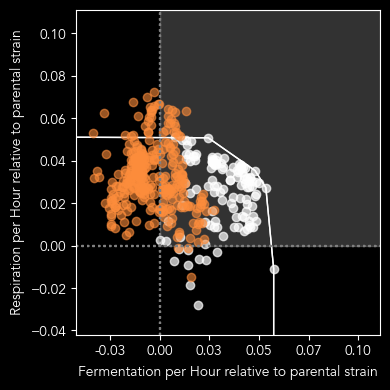

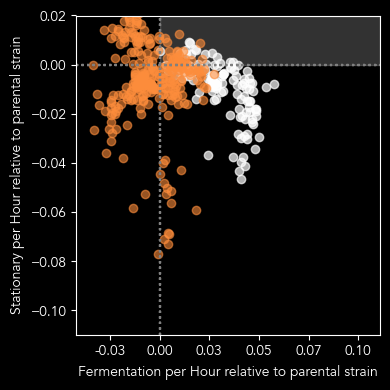

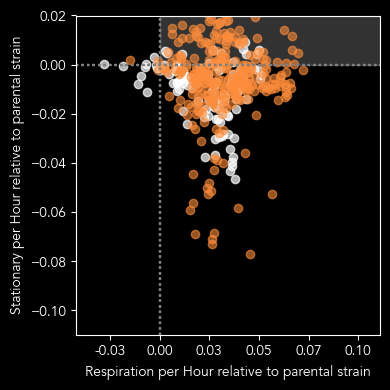

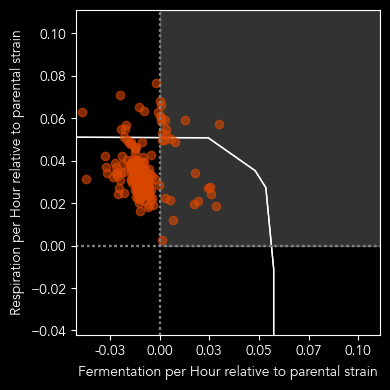

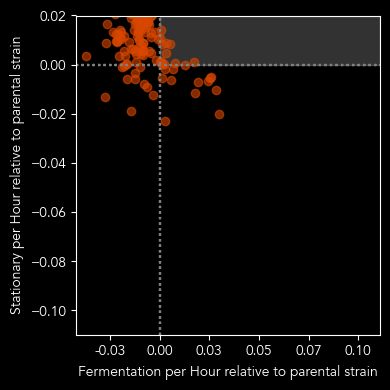

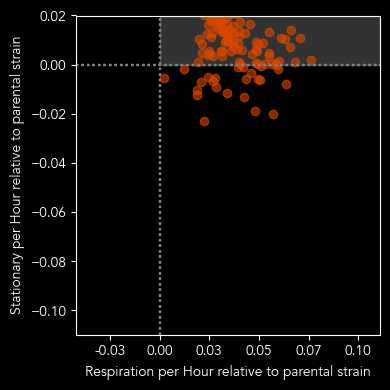

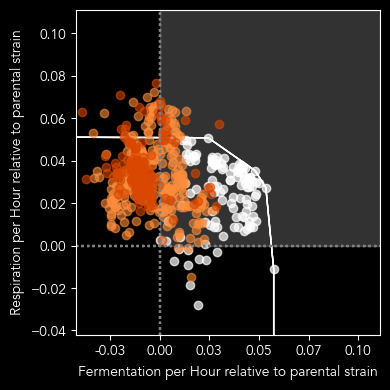

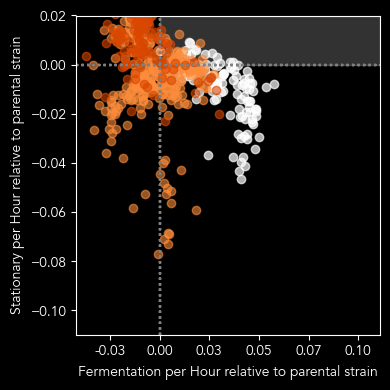

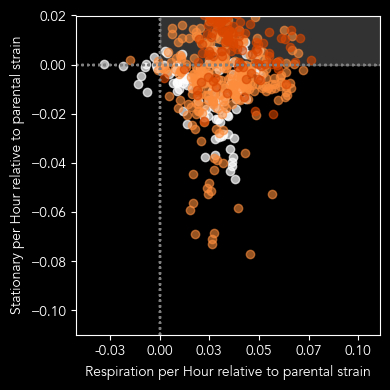

In [7]:
colors = [tools.anc_color_map[anc] for anc in merged_fitness['ancestor']]
# colors = ['b' if source=='This_study' else 'r' if source=='Li2019' else 'orange' if source == 'Aggeli2020' else 'k' for source in nonan_merged['source_publication_x']]

# non_diploid = merged_fitness[merged_fitness['ploidy']!='Diploid']

xlabel = 'Fermentation per Hour'
ylabel = 'Respiration per Hour'
xdata = 'FerPerHour'
ydata = 'ResPerHour'

xlabel = 'Stationary per Hour'
ylabel = 'Respiration per Hour'
xdata = 'StaPerHour'
ydata = 'ResPerHour'
labels = {'FerPerHour':'Fermentation per Hour','ResPerHour':'Respiration per Hour','StaPerHour':'Stationary per Hour'}
lims = {'FerPerHour':[-0.05,0.07],'ResPerHour':[-0.05,0.12],'StaPerHour':[-0.09,0.045]}


va_dict = {0:'bottom',1:'center',2:'top'}
ha_dict = {0:'left',1:'center',2:'right'}
# evo_cond_list = ['Evo1D']
# evo_cond_list = ['Evo2D']
# evo_cond_list = ['Evo3D']
evo_cond_list = [['Evo2D'],['Evo3D'],['Evo2D','Evo3D']]

fitness_colorby = 'Fit2D_early_fitness'
fitness_colorby = 'Fit3D_early_fitness'
fitness_colorby = 'StaPerHour'

errorbar = True
show_error = False
all_density = True


### cutoff for standard deviation
multiplier = 2.0
# multiplier = 1.96
multiplier = 0.0 

innovation_list = {}

noLi2019 = merged_fitness[merged_fitness['source_publication']!='Li2019']

anc_color = 'k'
if theme == 'dark':
    anc_color = 'w'



for evo_cond_set in evo_cond_list:
    for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
        b = 0
        ancestor_list = [['WT'],['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']]
        fig = plt.figure(figsize=(4,4))
        plt.fill_between([0,tools.lims[xdata][1]],0,tools.lims[ydata][1],
                                                color=anc_color,alpha=0.2)
        
        plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.2f'))

        for a,ancs in enumerate(ancestor_list):

            

            for evo_i,evo_cond in enumerate(evo_cond_set):
            
                this_anc = noLi2019[noLi2019['ancestor'].isin(ancs)]

                these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
                these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

                interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
                
                interesting_muts = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
                this_data = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
                gray_alpha = 0.1
                bold_alpha = 0.5
                
                if evo_cond == 'Evo2D':

                    fill = True
#                             color = 'orange'

#                             if len(evo_cond_set) == 1:
#                                 fill = False

                    wt_data = noLi2019[(noLi2019['ancestor']=='WT') & 
                                       ~(noLi2019['class_new']=='pure_diploids') & 
                                       ~(noLi2019['class_new']=='neutral_haploids')]
#                                 sns.kdeplot(x=wt_data[xdata+'_relative'].values,y=wt_data[ydata+'_relative'].values,
#                                                     color='k',fill=True,thresh=0.1,levels=9,
#                                                     alpha=0.8,label=evo_cond)
                   
                    if ancs == ['WT']:
                        plt.scatter(wt_data[xdata+'_relative'].values,wt_data[ydata+'_relative'].values,
                                color=anc_color,alpha=0.7)
                    else:
                        plt.scatter(this_data[xdata+'_relative'].values,this_data[ydata+'_relative'].values,
                                color=tools.anc_evo_cond_color_map['all_second_step'][evo_cond],alpha=0.6)
                else:
#                             print('skipping plotting Evo3D')
                    plt.scatter(this_data[xdata+'_relative'].values,this_data[ydata+'_relative'].values,
                                color=tools.anc_evo_cond_color_map['all_second_step'][evo_cond],alpha=0.6)


                
                
        
                if xdata == 'FerPerHour' and ydata == 'ResPerHour':
                    plt.plot(levy_pareto_line[0],levy_pareto_line[1],color=anc_color,lw=1,zorder=0)

                plt.xlim(tools.lims[xdata][0],tools.lims[xdata][1])
                plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])
            
                    
                tradeoff_means,tradeoff_stds = bootstrap_tradeoffs(interesting_muts[xdata+'_relative'].values,
                                                                  interesting_muts[ydata+'_relative'].values,
                                                                  interesting_muts[xdata+'_error'].values,
                                                                  interesting_muts[ydata+'_error'].values,
                            0,0,0,0,
                            multiplier=multiplier,use_both_errors=True,n_resamples=1000)

                xy_set = [(0,2),(2,0),(2,2)]

                offset = 0.01
                y_offset = 0.0
                if ancs != ['WT']:
                    y_offset = 0.05
                    if len(evo_cond_set) > 1:
                        if evo_cond == 'Evo3D':
                            y_offset += 0.05

                if ydata == 'StaPerHour':
                    xy_set.append((0,0))

                for (x,y) in xy_set:
                    if x == 1:
                        loc_x = (0-tools.lims[xdata][0])/(tools.lims[xdata][1]-tools.lims[xdata][0])
                    elif x == 0:
                        loc_x = x/2 + offset
                    else:
                        loc_x = x/2 - offset

                    if y == 1:
                        loc_y = (0-tools.lims[ydata][0])/(tools.lims[ydata][1]-tools.lims[ydata][0])
                    elif y == 0:
                        loc_y = y/2 + offset + y_offset
                    else:
                        loc_y = y/2 - offset - y_offset

                    show_tradeoffs = True
#                         this_color = 'orange'
#                         if len(evo_cond_set) > 1:
#                             if evo_cond == 'Evo3D':
#                                 this_color='b'
#                                 show_tradeoffs = False

#                     if ancs != ['WT']:
#                         if not p.isnull(tradeoff_means[x][y]) and show_tradeoffs:
#                             plt.text(s=f'{tradeoff_means[x][y]:.0%}\u00B1{tradeoff_stds[x][y]:.0%}',
#                                  x=loc_x,y=loc_y,transform=plt.gca().transAxes,fontsize=12,
#                                  ha=ha_dict[x],va=va_dict[y],color=tools.anc_evo_cond_color_map['all_second_step'][evo_cond])
#                     else:
#                         if not p.isnull(tradeoff_means[x][y]) and show_tradeoffs:
#                             plt.text(s=f'{tradeoff_means[x][y]:.0%}\u00B1{tradeoff_stds[x][y]:.0%}',
#                                  x=loc_x,y=loc_y,transform=plt.gca().transAxes,fontsize=12,
#                                  ha=ha_dict[x],va=va_dict[y],color=anc_color)


                    
                    plt.xlabel(f'{labels[xdata]} relative to parental strain')
                    plt.ylabel(f'{labels[ydata]} relative to parental strain')
                    

                    plt.axvline(0,color='gray',linestyle=':')
                    plt.axhline(0,color='gray',linestyle=':')


                    plt.tight_layout()
                    
                

                plt.savefig(f'{home_dir}/talk_figures/{theme}/tradeoffs_{xdata}_{ydata}_buildup{b}.pdf',bbox_inches='tight')

                b+= 1
                
                if ancs == ['WT']:
                    
                    temporaryPoints = []
                    
                    for anc2 in tools.rebarcoding_source_mutants.keys():
                        background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc2]]

                        this_anc = plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                                marker='o',color=tools.anc_color_map[anc2],s=100)
                        
                        temporaryPoints.append(this_anc)
                    
                    plt.savefig(f'{home_dir}/talk_figures/{theme}/tradeoffs_{xdata}_{ydata}_buildup{b}.pdf',bbox_inches='tight')

                    b+= 1
                    
                    for plot in temporaryPoints:
                        plot.remove()

In [8]:
np.max(merged_fitness[(merged_fitness['ancestor']=='WT') & 
               (merged_fitness['evolution_condition']=='Evo2D')][['FerPerHour','ResPerHour']])

/Users/grantkinsler/opt/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


FerPerHour    0.057438
ResPerHour    0.051075
dtype: float64

In [22]:
(16*0.057438 + 28*0.051075)/8

0.2936385

In [24]:
(16*0.057438 + 4*0.051075)

1.123308

/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_23454/1673457357.py:22: RuntimeWarning: invalid value encountered in divide
  resampling_matrix[resampling,:,:] = np.asarray(improvement_matrix)/n_obs
/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_23454/1673457357.py:22: RuntimeWarning: invalid value encountered in divide
  resampling_matrix[resampling,:,:] = np.asarray(improvement_matrix)/n_obs
/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_23454/1673457357.py:22: RuntimeWarning: invalid value encountered in divide
  resampling_matrix[resampling,:,:] = np.asarray(improvement_matrix)/n_obs
/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_23454/1673457357.py:22: RuntimeWarning: invalid value encountered in divide
  resampling_matrix[resampling,:,:] = np.asarray(improvement_matrix)/n_obs
/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_23454/1673457357.py:22: RuntimeWarning: invalid value encountered in divide
  resampling_matrix[resam

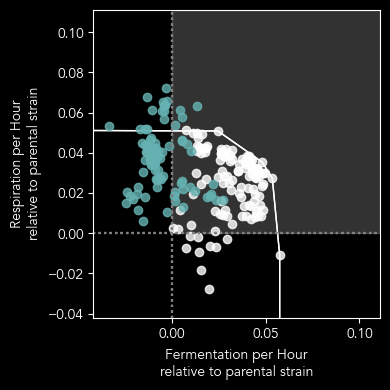

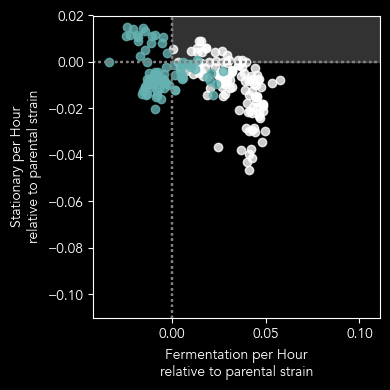

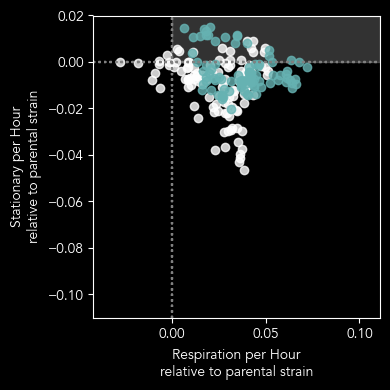

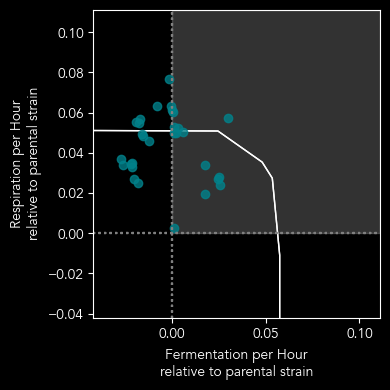

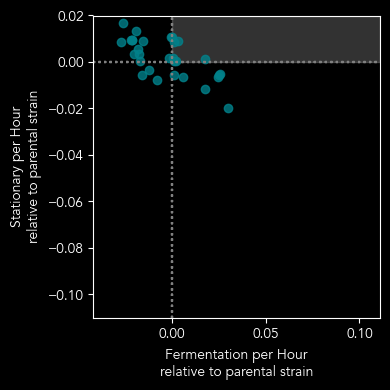

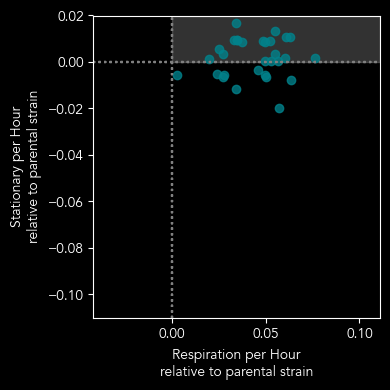

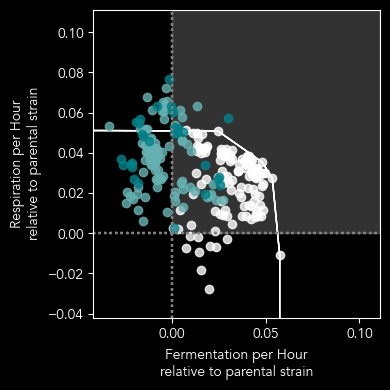

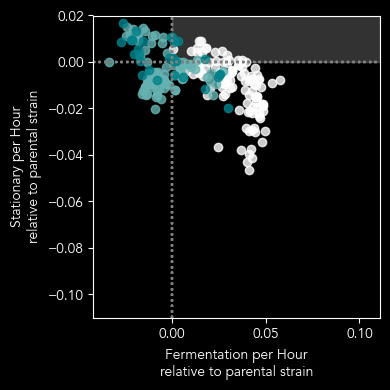

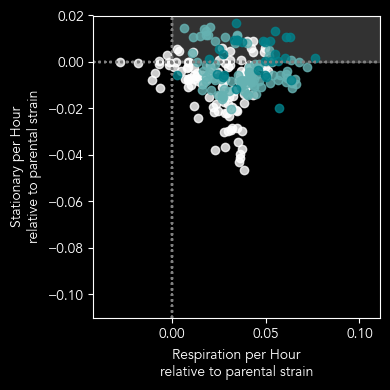

In [11]:
colors = [tools.anc_color_map[anc] for anc in merged_fitness['ancestor']]
# colors = ['b' if source=='This_study' else 'r' if source=='Li2019' else 'orange' if source == 'Aggeli2020' else 'k' for source in nonan_merged['source_publication_x']]

# non_diploid = merged_fitness[merged_fitness['ploidy']!='Diploid']

xlabel = 'Fermentation per Hour'
ylabel = 'Respiration per Hour'
xdata = 'FerPerHour'
ydata = 'ResPerHour'

xlabel = 'Stationary per Hour'
ylabel = 'Respiration per Hour'
xdata = 'StaPerHour'
ydata = 'ResPerHour'
labels = {'FerPerHour':'Fermentation per Hour','ResPerHour':'Respiration per Hour','StaPerHour':'Stationary per Hour'}
lims = {'FerPerHour':[-0.05,0.07],'ResPerHour':[-0.05,0.12],'StaPerHour':[-0.09,0.045]}


va_dict = {0:'bottom',1:'center',2:'top'}
ha_dict = {0:'left',1:'center',2:'right'}
# evo_cond_list = ['Evo1D']
# evo_cond_list = ['Evo2D']
# evo_cond_list = ['Evo3D']
evo_cond_list = [['Evo2D'],['Evo3D'],['Evo2D','Evo3D']]

fitness_colorby = 'Fit2D_early_fitness'
fitness_colorby = 'Fit3D_early_fitness'
fitness_colorby = 'StaPerHour'

errorbar = True
show_error = False
all_density = True


### cutoff for standard deviation
multiplier = 2.0
# multiplier = 1.96
multiplier = 0.0 

innovation_list = {}

noLi2019 = merged_fitness[merged_fitness['source_publication']!='Li2019']

anc_color = 'k'
if theme == 'dark':
    anc_color = 'w'



for evo_cond_set in evo_cond_list:
    for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
        b = 0
        ancestor_list = [['WT'],['IRA1_MIS']]
        fig = plt.figure(figsize=(4,4))
        plt.fill_between([0,tools.lims[xdata][1]],0,tools.lims[ydata][1],
                                                color=anc_color,alpha=0.2)
        
#         plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.2f'))

        for a,ancs in enumerate(ancestor_list):

            

            for evo_i,evo_cond in enumerate(evo_cond_set):
            
                this_anc = noLi2019[noLi2019['ancestor'].isin(ancs)]

                these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
                these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

                interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
                
                interesting_muts = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
                this_data = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
                gray_alpha = 0.1
                bold_alpha = 0.5
                
                if evo_cond == 'Evo2D':

                    fill = True
#                             color = 'orange'

#                             if len(evo_cond_set) == 1:
#                                 fill = False

                    wt_data = noLi2019[(noLi2019['ancestor']=='WT') & 
                                       ~(noLi2019['class_new']=='pure_diploids') & 
                                       ~(noLi2019['class_new']=='neutral_haploids')]
#                                 sns.kdeplot(x=wt_data[xdata+'_relative'].values,y=wt_data[ydata+'_relative'].values,
#                                                     color='k',fill=True,thresh=0.1,levels=9,
#                                                     alpha=0.8,label=evo_cond)
                   
                    if ancs == ['WT']:
                        plt.scatter(wt_data[xdata+'_relative'].values,wt_data[ydata+'_relative'].values,
                                color=anc_color,alpha=0.8)
                    else:
                        plt.scatter(this_data[xdata+'_relative'].values,this_data[ydata+'_relative'].values,
                                color=tools.anc_evo_cond_color_map['IRA1_MIS'][evo_cond],alpha=0.8)
                else:
#                             print('skipping plotting Evo3D')
                    plt.scatter(this_data[xdata+'_relative'].values,this_data[ydata+'_relative'].values,
                                color=tools.anc_evo_cond_color_map['IRA1_MIS'][evo_cond],alpha=0.8)


                
                
        
                if xdata == 'FerPerHour' and ydata == 'ResPerHour':
                    plt.plot(levy_pareto_line[0],levy_pareto_line[1],color=anc_color,lw=1,zorder=0)

                plt.xlim(tools.lims[xdata][0],tools.lims[xdata][1])
                plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])
            
                    
                tradeoff_means,tradeoff_stds = bootstrap_tradeoffs(interesting_muts[xdata+'_relative'].values,
                                                                  interesting_muts[ydata+'_relative'].values,
                                                                  interesting_muts[xdata+'_error'].values,
                                                                  interesting_muts[ydata+'_error'].values,
                            0,0,0,0,
                            multiplier=multiplier,use_both_errors=True,n_resamples=1000)

                xy_set = [(0,2),(2,0),(2,2)]

                offset = 0.01
                y_offset = 0.0
                if ancs != ['WT']:
                    y_offset = 0.05
                    if len(evo_cond_set) > 1:
                        if evo_cond == 'Evo3D':
                            y_offset += 0.05

                if ydata == 'StaPerHour':
                    xy_set.append((0,0))

                for (x,y) in xy_set:
                    if x == 1:
                        loc_x = (0-tools.lims[xdata][0])/(tools.lims[xdata][1]-tools.lims[xdata][0])
                    elif x == 0:
                        loc_x = x/2 + offset
                    else:
                        loc_x = x/2 - offset

                    if y == 1:
                        loc_y = (0-tools.lims[ydata][0])/(tools.lims[ydata][1]-tools.lims[ydata][0])
                    elif y == 0:
                        loc_y = y/2 + offset + y_offset
                    else:
                        loc_y = y/2 - offset - y_offset

                    show_tradeoffs = True
#                         this_color = 'orange'
#                         if len(evo_cond_set) > 1:
#                             if evo_cond == 'Evo3D':
#                                 this_color='b'
#                                 show_tradeoffs = False

#                     if ancs != ['WT']:
#                         if not p.isnull(tradeoff_means[x][y]) and show_tradeoffs:
#                             plt.text(s=f'{tradeoff_means[x][y]:.0%}\u00B1{tradeoff_stds[x][y]:.0%}',
#                                  x=loc_x,y=loc_y,transform=plt.gca().transAxes,fontsize=12,
#                                  ha=ha_dict[x],va=va_dict[y],color=tools.anc_evo_cond_color_map['all_second_step'][evo_cond])
#                     else:
#                         if not p.isnull(tradeoff_means[x][y]) and show_tradeoffs:
#                             plt.text(s=f'{tradeoff_means[x][y]:.0%}\u00B1{tradeoff_stds[x][y]:.0%}',
#                                  x=loc_x,y=loc_y,transform=plt.gca().transAxes,fontsize=12,
#                                  ha=ha_dict[x],va=va_dict[y],color=anc_color)


                    
                    plt.xlabel(f'{labels[xdata]}\nrelative to parental strain')
                    plt.ylabel(f'{labels[ydata]}\nrelative to parental strain')
                    

                    plt.axvline(0,color='gray',linestyle=':')
                    plt.axhline(0,color='gray',linestyle=':')


                    plt.tight_layout()
                    
                

                plt.savefig(f'{home_dir}/talk_figures/{theme}/tradeoffs_abs_IRA1mis_{xdata}_{ydata}_buildup{b}.pdf',bbox_inches='tight')

                b+= 1
                
                if ancs == ['WT']:
                    
                    temporaryPoints = []
                    
                    for anc2 in tools.rebarcoding_source_mutants.keys():
                        background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc2]]

                        this_anc = plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                                marker='o',color=tools.anc_color_map[anc2],s=80)
                        
                        temporaryPoints.append(this_anc)
                    
                    plt.savefig(f'{home_dir}/talk_figures/{theme}/tradeoffs_abs_IRA1mis_{xdata}_{ydata}_buildup{b}.pdf',bbox_inches='tight')

                    b+= 1
                    
                    for plot in temporaryPoints:
                        plot.remove()

/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_23454/1673457357.py:22: RuntimeWarning: invalid value encountered in divide
  resampling_matrix[resampling,:,:] = np.asarray(improvement_matrix)/n_obs
/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_23454/1673457357.py:22: RuntimeWarning: invalid value encountered in divide
  resampling_matrix[resampling,:,:] = np.asarray(improvement_matrix)/n_obs
/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_23454/1673457357.py:22: RuntimeWarning: invalid value encountered in divide
  resampling_matrix[resampling,:,:] = np.asarray(improvement_matrix)/n_obs
/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_23454/1673457357.py:22: RuntimeWarning: invalid value encountered in divide
  resampling_matrix[resampling,:,:] = np.asarray(improvement_matrix)/n_obs
/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_23454/1673457357.py:22: RuntimeWarning: invalid value encountered in divide
  resampling_matrix[resam

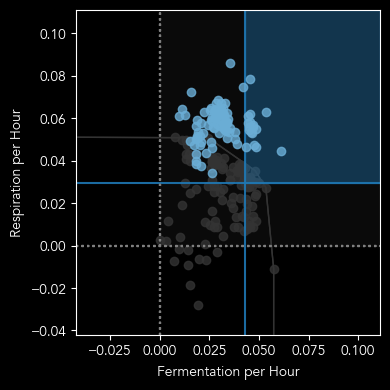

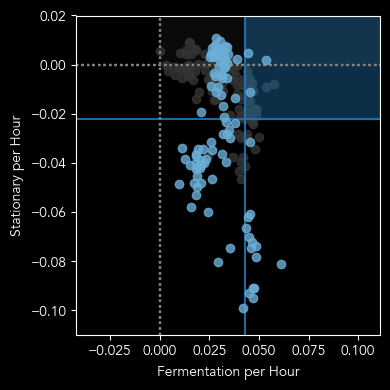

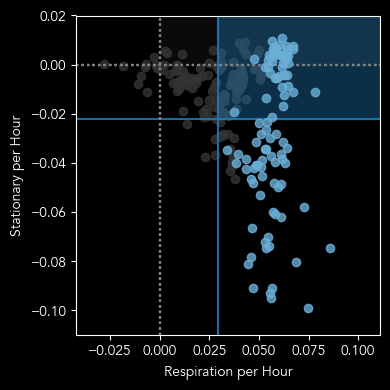

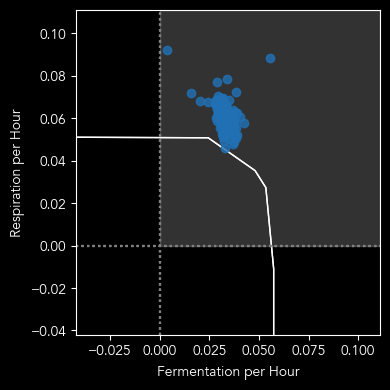

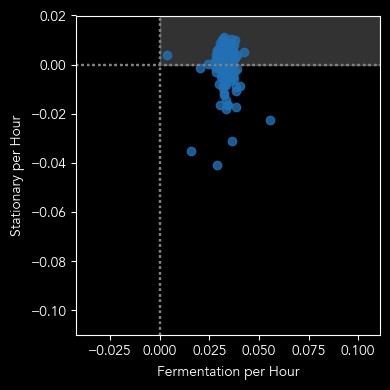

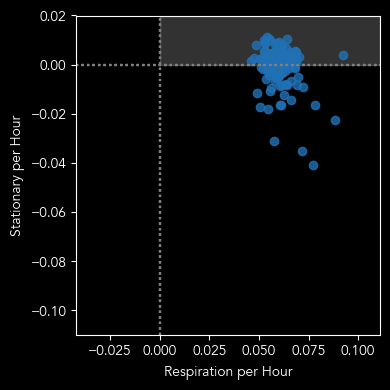

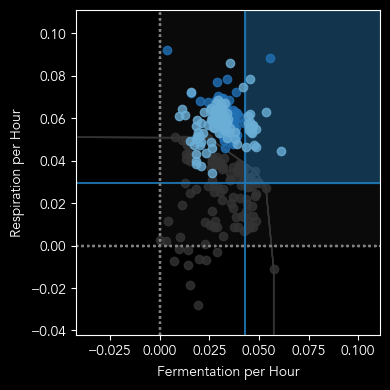

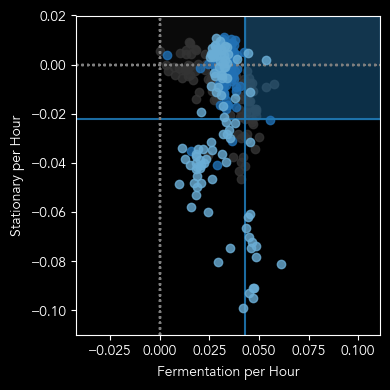

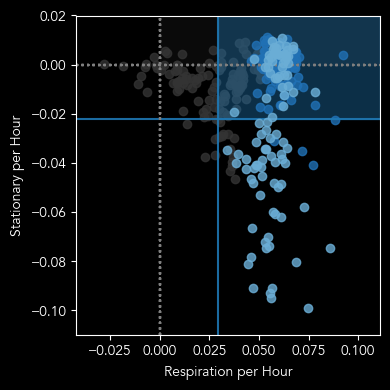

In [56]:
colors = [tools.anc_color_map[anc] for anc in merged_fitness['ancestor']]
# colors = ['b' if source=='This_study' else 'r' if source=='Li2019' else 'orange' if source == 'Aggeli2020' else 'k' for source in nonan_merged['source_publication_x']]

# non_diploid = merged_fitness[merged_fitness['ploidy']!='Diploid']

xlabel = 'Fermentation per Hour'
ylabel = 'Respiration per Hour'
xdata = 'FerPerHour'
ydata = 'ResPerHour'

xlabel = 'Stationary per Hour'
ylabel = 'Respiration per Hour'
xdata = 'StaPerHour'
ydata = 'ResPerHour'
labels = {'FerPerHour':'Fermentation per Hour','ResPerHour':'Respiration per Hour','StaPerHour':'Stationary per Hour'}
lims = {'FerPerHour':[-0.05,0.07],'ResPerHour':[-0.05,0.12],'StaPerHour':[-0.09,0.045]}


va_dict = {0:'bottom',1:'center',2:'top'}
ha_dict = {0:'left',1:'center',2:'right'}
# evo_cond_list = ['Evo1D']
# evo_cond_list = ['Evo2D']
# evo_cond_list = ['Evo3D']
evo_cond_list = [['Evo2D'],['Evo3D'],['Evo2D','Evo3D']]

fitness_colorby = 'Fit2D_early_fitness'
fitness_colorby = 'Fit3D_early_fitness'
fitness_colorby = 'StaPerHour'

errorbar = True
show_error = False
all_density = True


### cutoff for standard deviation
multiplier = 2.0
# multiplier = 1.96
multiplier = 0.0 

innovation_list = {}

noLi2019 = merged_fitness[merged_fitness['source_publication']!='Li2019']

anc_color = 'k'
if theme == 'dark':
    anc_color = 'w'



for evo_cond_set in evo_cond_list:
    for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
        b = 0
        ancestor_list = [['WT'],['IRA1_NON']]
        fig = plt.figure(figsize=(4,4))
        plt.fill_between([0,tools.lims[xdata][1]],0,tools.lims[ydata][1],
                                                color=anc_color,alpha=0.2)
        
#         plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.2f'))

        for a,ancs in enumerate(ancestor_list):

            for evo_i,evo_cond in enumerate(evo_cond_set):
            
                this_anc = noLi2019[noLi2019['ancestor'].isin(ancs)]

                these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
                these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

                interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
                
                interesting_muts = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
                this_data = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
                gray_alpha = 0.1
                bold_alpha = 0.5
                
                if evo_cond == 'Evo2D':

                    fill = True
#                             color = 'orange'

#                             if len(evo_cond_set) == 1:
#                                 fill = False

                    wt_data = noLi2019[(noLi2019['ancestor']=='WT') & 
                                       ~(noLi2019['class_new']=='pure_diploids') & 
                                       ~(noLi2019['class_new']=='neutral_haploids')]
#                                 sns.kdeplot(x=wt_data[xdata+'_relative'].values,y=wt_data[ydata+'_relative'].values,
#                                                     color='k',fill=True,thresh=0.1,levels=9,
#                                                     alpha=0.8,label=evo_cond)
                   
                    if ancs == ['WT']:
                        plt.scatter(wt_data[xdata].values,wt_data[ydata].values,
                                color=anc_color,alpha=0.8)
                    else:
                        
                        anc = ancs[0]
                                        
                        if ancs != ['IRA1_NON']:

                            x_mean = np.nanmedian(this_neutral_haploid[xdata].values)
                            x_error = np.nanstd(this_neutral_haploid[xdata].values)/len(this_neutral_haploid[xdata].values)
                            y_mean = np.nanmedian(this_neutral_haploid[ydata].values)
                            y_error = np.nanstd(this_neutral_haploid[ydata].values)/len(this_neutral_haploid[ydata].values)
                        
                        else:
                            background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants['IRA1_NON']]
                            
                            x_mean = background_mutant[xdata].values[0]
                            y_mean = background_mutant[ydata].values
                        
                        if ancs != ['WT']:
                            plt.axvline(x_mean,color=tools.anc_color_map[anc],alpha=0.9)
                            plt.axhline(y_mean,color=tools.anc_color_map[anc],alpha=0.9)

                            if evo_i == 0:

                                plt.fill_between([tools.lims[xdata][0],tools.lims[xdata][1]],tools.lims[ydata][0],tools.lims[ydata][1],
                                            color='k',alpha=0.8)
                                plt.fill_between([x_mean,tools.lims[xdata][1]],y_mean,tools.lims[ydata][1],
                                            color=tools.anc_color_map[anc],alpha=0.4)

                        
                        plt.savefig(f'{home_dir}/talk_figures/{theme}/tradeoffs_abs_{ancestor_list[1][0]}_{xdata}_{ydata}_buildup{b}.pdf',bbox_inches='tight')
                        b+=1
                                    
                        plt.scatter(this_data[xdata].values,this_data[ydata].values,
                                color=tools.anc_evo_cond_color_map[ancs[0]][evo_cond],alpha=0.8,zorder=3)
                else:
#                             print('skipping plotting Evo3D')
                    plt.scatter(this_data[xdata].values,this_data[ydata].values,
                                color=tools.anc_evo_cond_color_map[ancs[0]][evo_cond],alpha=0.8)


                
                
        
                if xdata == 'FerPerHour' and ydata == 'ResPerHour':
                    plt.plot(levy_pareto_line[0],levy_pareto_line[1],color=anc_color,lw=1,zorder=0)

                plt.xlim(tools.lims[xdata][0],tools.lims[xdata][1])
                plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])
            
                    
                tradeoff_means,tradeoff_stds = bootstrap_tradeoffs(interesting_muts[xdata+'_relative'].values,
                                                                  interesting_muts[ydata+'_relative'].values,
                                                                  interesting_muts[xdata+'_error'].values,
                                                                  interesting_muts[ydata+'_error'].values,
                            0,0,0,0,
                            multiplier=multiplier,use_both_errors=True,n_resamples=1000)

                xy_set = [(0,2),(2,0),(2,2)]

                offset = 0.01
                y_offset = 0.0
                if ancs != ['WT']:
                    y_offset = 0.05
                    if len(evo_cond_set) > 1:
                        if evo_cond == 'Evo3D':
                            y_offset += 0.05

                if ydata == 'StaPerHour':
                    xy_set.append((0,0))

                for (x,y) in xy_set:
                    if x == 1:
                        loc_x = (0-tools.lims[xdata][0])/(tools.lims[xdata][1]-tools.lims[xdata][0])
                    elif x == 0:
                        loc_x = x/2 + offset
                    else:
                        loc_x = x/2 - offset

                    if y == 1:
                        loc_y = (0-tools.lims[ydata][0])/(tools.lims[ydata][1]-tools.lims[ydata][0])
                    elif y == 0:
                        loc_y = y/2 + offset + y_offset
                    else:
                        loc_y = y/2 - offset - y_offset

                    show_tradeoffs = True
#                         this_color = 'orange'
#                         if len(evo_cond_set) > 1:
#                             if evo_cond == 'Evo3D':
#                                 this_color='b'
#                                 show_tradeoffs = False

#                     if ancs != ['WT']:
#                         if not p.isnull(tradeoff_means[x][y]) and show_tradeoffs:
#                             plt.text(s=f'{tradeoff_means[x][y]:.0%}\u00B1{tradeoff_stds[x][y]:.0%}',
#                                  x=loc_x,y=loc_y,transform=plt.gca().transAxes,fontsize=12,
#                                  ha=ha_dict[x],va=va_dict[y],color=tools.anc_evo_cond_color_map['IRA1_MIS'][evo_cond])
#                     else:
#                         if not p.isnull(tradeoff_means[x][y]) and show_tradeoffs:
#                             plt.text(s=f'{tradeoff_means[x][y]:.0%}\u00B1{tradeoff_stds[x][y]:.0%}',
#                                  x=loc_x,y=loc_y,transform=plt.gca().transAxes,fontsize=12,
#                                  ha=ha_dict[x],va=va_dict[y],color=anc_color)


                    
                    plt.xlabel(f'{labels[xdata]}')
                    plt.ylabel(f'{labels[ydata]}')
                    

                    plt.axvline(0,color='gray',linestyle=':')
                    plt.axhline(0,color='gray',linestyle=':')


                    plt.tight_layout()
                    
                

                plt.savefig(f'{home_dir}/talk_figures/{theme}/tradeoffs_abs_{ancestor_list[1][0]}_{xdata}_{ydata}_buildup{b}.pdf',bbox_inches='tight')

                b+= 1
                

                            
                
                if ancs == ['WT']:
                    
                    temporaryPoints = []
                    
                    for anc2 in ancestor_list[1]:
                        background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc2]]

                        this_anc = plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                                marker='o',color=tools.anc_color_map[anc2],s=80)
                        
                        temporaryPoints.append(this_anc)
                    
                    plt.savefig(f'{home_dir}/talk_figures/{theme}/tradeoffs_abs_{ancestor_list[1][0]}_{xdata}_{ydata}_buildup{b}.pdf',bbox_inches='tight')

                    b+= 1
                    
                    for plot in temporaryPoints:
                        plot.remove()

In [14]:
interesting_genes = {'IRA1_NON':['KSP1+TAN1','KSP1+GSH1','KSP1+PUF3'],
                     'IRA1_MIS':['IRA1+MKT1+SPB1'],
#                      'GPB2':[]
                    }

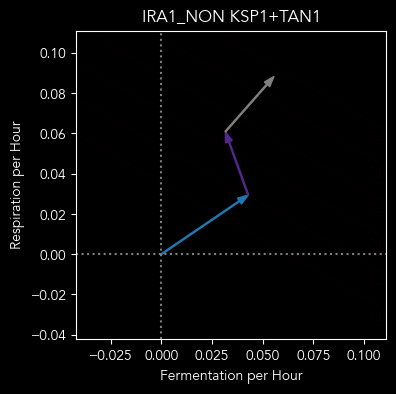

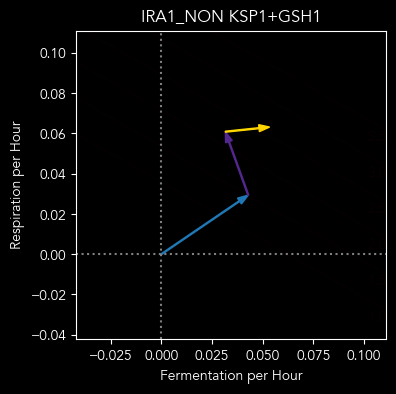

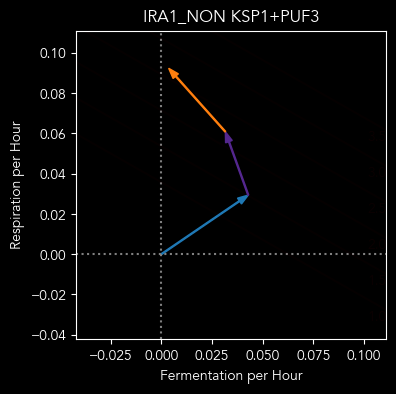

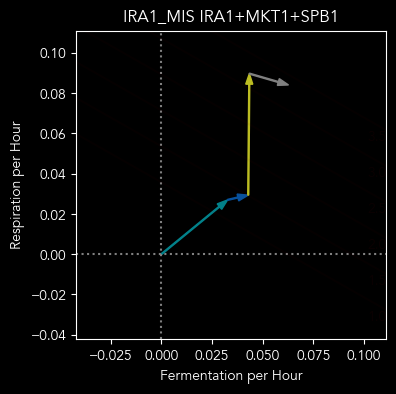

In [15]:

xdata = 'FerPerHour'
ydata = 'ResPerHour'

arrow_args = {'length_includes_head':True,
              'width':0.0005,
              'head_width':7*0.0005
             }

for anc,gene_list in interesting_genes.items():
    
    this_anc = merged_fitness[(merged_fitness['ancestor']==anc) & (merged_fitness['evolution_condition'].isin(['Evo2D','Evo3D']))]
    this_set = this_anc[~this_anc['class_new'].isin(['pure_diploids','neutral_haploids'])]
#     plt.scatter(this_set[xdata],this_set[ydata],marker='.',color='k',alpha=0.1) 
    this_neutral_haploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='neutral_haploids')]
    this_pure_diploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='pure_diploids')]
    adaptive_haploids = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='adaptive_haploid')]
    
    for gene_set in gene_list:
        
        plt.figure(figsize=(4,4))
        plt.title(f'{anc} {gene_set}')
        
        diploid = False
        this_mutant = this_set[this_set['gene']==gene_set]
        if this_mutant['class_new'].values[0] != 'adaptive_haploid':
            diploid = True
        
        plt.scatter(this_mutant[xdata],this_mutant[ydata],color='k',marker='o')
        
        location = np.asarray([0,0])
        
        plt.arrow(location[0],location[1],
                  this_set[xdata+'_ancestor'].values[0],
                  this_set[ydata+'_ancestor'].values[0],
                 color=tools.anc_color_map[anc],**arrow_args)
        
        location = location + [this_set[xdata+'_ancestor'].values[0],this_set[ydata+'_ancestor'].values[0]]
        
        if diploid:
            plt.arrow(location[0],location[1],
                  np.median(this_pure_diploid[xdata+'_relative'].values),
                      np.median(this_pure_diploid[xdata+'_relative'].values),
                 color='k',linestyle='--',**arrow_args)
            
            location = location +  [np.median(this_pure_diploid[xdata+'_relative'].values),
                      np.median(this_pure_diploid[xdata+'_relative'].values)]
        
        genes_unfurled = gene_set.split('+')
        
        for gene in genes_unfurled:
            
            if gene == 'IRA1':
                
                    this_gene = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants['IRA1_NON']]
                    
                    plt.arrow(location[0],location[1],
                          np.median(this_gene[xdata+'_relative'].values)-location[0],
                         np.median(this_gene[ydata+'_relative'].values)-location[1],
                         color=tools.mutation_color_map[gene],linestyle='-',**arrow_args)

                    location = location+ [np.median(this_gene[xdata+'_relative'].values)-location[0],
                                        np.median(this_gene[ydata+'_relative'].values)-location[1]]


                
            
            elif gene != genes_unfurled[-1]:
            
                this_gene = adaptive_haploids[adaptive_haploids['gene']==gene]
    #             np.median()

                if len(this_gene) > 1:

                    plt.arrow(location[0],location[1],
                          np.median(this_gene[xdata+'_relative'].values),
                         np.median(this_gene[ydata+'_relative'].values),
                         color=tools.mutation_color_map[gene],linestyle='-',**arrow_args)

                    location = location+ [np.median(this_gene[xdata+'_relative'].values),np.median(this_gene[ydata+'_relative'].values)]
            else:
                
                plt.arrow(location[0],location[1],
                      this_mutant[xdata].values[0]-location[0],this_mutant[ydata].values[0]-location[1],
                     color=tools.find_mutation_color(gene),linestyle='-',**arrow_args)
        
        
        plt.xlim(tools.lims[xdata][0],tools.lims[xdata][1])
        plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])

#         plt.axhline(this_set[ydata+'_ancestor'].values[0],color=tools.anc_color_map[anc],alpha=0.5)
#         plt.axvline(this_set[xdata+'_ancestor'].values[0],color=tools.anc_color_map[anc],alpha=0.5)

        plt.axvline(0,color='gray',linestyle=':')
        plt.axhline(0,color='gray',linestyle=':')

        plt.xlabel('Fermentation per Hour')
        plt.ylabel('Respiration per Hour')
        
        for fitness in [1.0,1.5,2.0,2.5,3.0,3.5]:
            ferms = np.linspace(tools.lims[xdata][0],tools.lims[xdata][1],100)
            resps = (fitness-16*ferms)/28 # 2day = 16*F

            norm = matplotlib.colors.Normalize(vmin=np.nanmin(merged_fitness[fitness_colorby]),
                    vmax=np.nanmax(merged_fitness[fitness_colorby]))

            cm = matplotlib.cm.ScalarMappable(norm=norm, cmap='Reds') 

            plt.plot(ferms,resps,color=cm.to_rgba(fitness),alpha=0.05)
            plt.text(x=ferms[-1],y=resps[-1],s=f'{fitness}',color=cm.to_rgba(fitness),alpha=0.1,ha='right',va='top')


        plt.savefig(f'{home_dir}/talk_figures/innovation_{anc}_{gene_set}.pdf',bbox_inches='tight')

        

/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_23454/1673457357.py:22: RuntimeWarning: invalid value encountered in divide
  resampling_matrix[resampling,:,:] = np.asarray(improvement_matrix)/n_obs
/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_23454/1673457357.py:22: RuntimeWarning: invalid value encountered in divide
  resampling_matrix[resampling,:,:] = np.asarray(improvement_matrix)/n_obs
/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_23454/1673457357.py:22: RuntimeWarning: invalid value encountered in divide
  resampling_matrix[resampling,:,:] = np.asarray(improvement_matrix)/n_obs
/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_23454/1673457357.py:22: RuntimeWarning: invalid value encountered in divide
  resampling_matrix[resampling,:,:] = np.asarray(improvement_matrix)/n_obs
/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_23454/1673457357.py:22: RuntimeWarning: invalid value encountered in divide
  resampling_matrix[resam

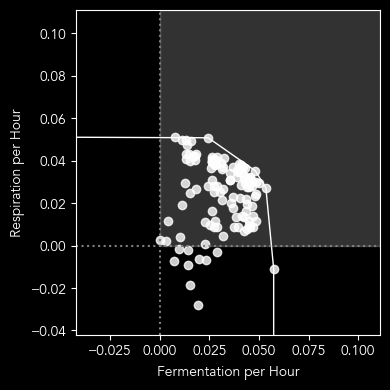

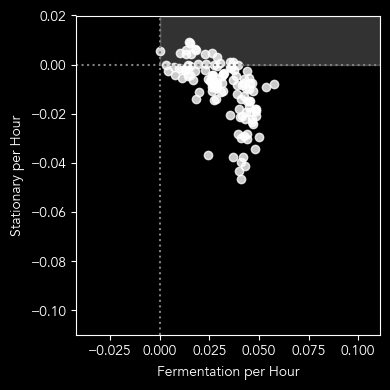

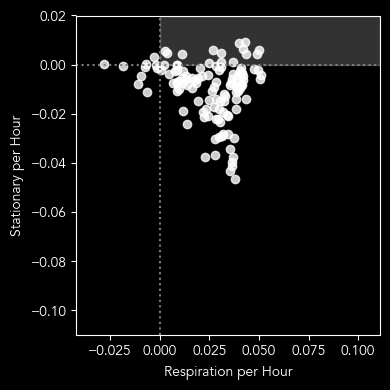

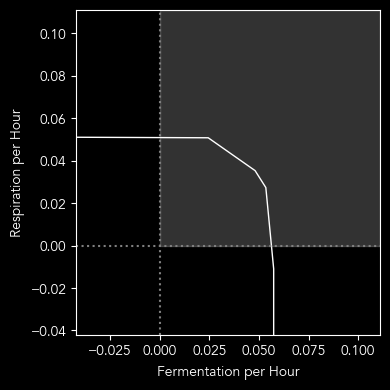

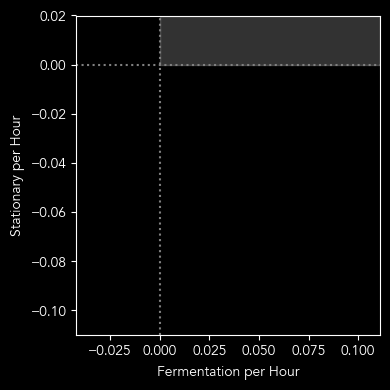

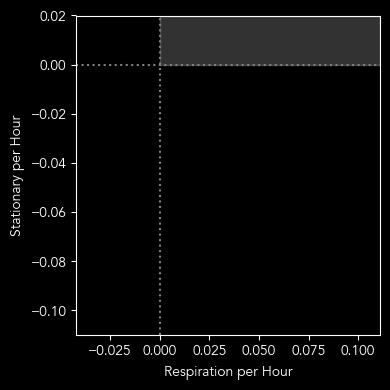

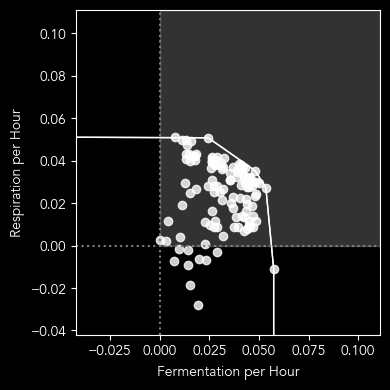

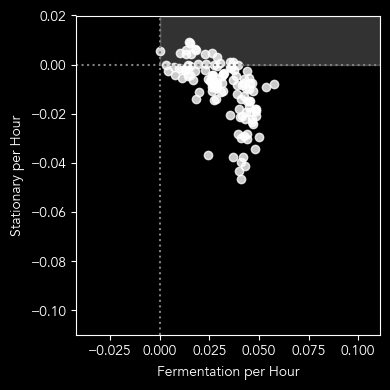

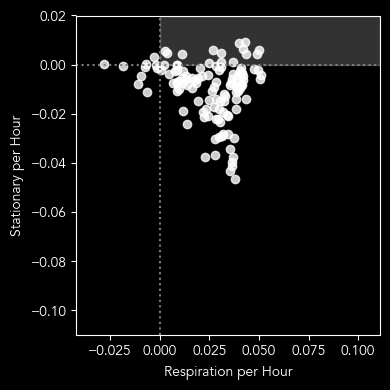

In [31]:
colors = [tools.anc_color_map[anc] for anc in merged_fitness['ancestor']]
# colors = ['b' if source=='This_study' else 'r' if source=='Li2019' else 'orange' if source == 'Aggeli2020' else 'k' for source in nonan_merged['source_publication_x']]

# non_diploid = merged_fitness[merged_fitness['ploidy']!='Diploid']

xlabel = 'Fermentation per Hour'
ylabel = 'Respiration per Hour'
xdata = 'FerPerHour'
ydata = 'ResPerHour'

xlabel = 'Stationary per Hour'
ylabel = 'Respiration per Hour'
xdata = 'StaPerHour'
ydata = 'ResPerHour'
labels = {'FerPerHour':'Fermentation per Hour','ResPerHour':'Respiration per Hour','StaPerHour':'Stationary per Hour'}
lims = {'FerPerHour':[-0.05,0.07],'ResPerHour':[-0.05,0.12],'StaPerHour':[-0.09,0.045]}


va_dict = {0:'bottom',1:'center',2:'top'}
ha_dict = {0:'left',1:'center',2:'right'}
# evo_cond_list = ['Evo1D']
# evo_cond_list = ['Evo2D']
# evo_cond_list = ['Evo3D']
evo_cond_list = [['Evo2D'],['Evo3D'],['Evo2D','Evo3D']]

fitness_colorby = 'Fit2D_early_fitness'
fitness_colorby = 'Fit3D_early_fitness'
fitness_colorby = 'StaPerHour'

errorbar = True
show_error = False
all_density = True


### cutoff for standard deviation
multiplier = 2.0
# multiplier = 1.96
multiplier = 0.0 

innovation_list = {}

noLi2019 = merged_fitness[merged_fitness['source_publication']!='Li2019']

anc_color = 'k'
if theme == 'dark':
    anc_color = 'w'



for evo_cond_set in evo_cond_list:
    for xdata,ydata in combinations(['FerPerHour','ResPerHour','StaPerHour'],2):
        b = 0
        ancestor_list = [['WT']]
        fig = plt.figure(figsize=(4,4))
        plt.fill_between([0,tools.lims[xdata][1]],0,tools.lims[ydata][1],
                                                color=anc_color,alpha=0.2)
        
        
                
        
                   
        plt.xlabel(f'{labels[xdata]}')
        plt.ylabel(f'{labels[ydata]}')


        plt.axvline(0,color='gray',linestyle=':')
        plt.axhline(0,color='gray',linestyle=':')
        
        plt.xlim(tools.lims[xdata][0],tools.lims[xdata][1])
        plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])


        plt.tight_layout()



        plt.savefig(f'{home_dir}/talk_figures/{theme}/tradeoffs_ancestors_{xdata}_{ydata}_buildup{b}.pdf',bbox_inches='tight')

        b+= 1
        
#         plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.2f'))

        for a,ancs in enumerate(ancestor_list):

            for evo_i,evo_cond in enumerate(evo_cond_set):
            
                this_anc = noLi2019[noLi2019['ancestor'].isin(ancs)]

                these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
                these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

                interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]
                
                interesting_muts = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
                this_data = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
                gray_alpha = 0.1
                bold_alpha = 0.5
                
                if evo_cond == 'Evo2D':

                    fill = True
#                             color = 'orange'

#                             if len(evo_cond_set) == 1:
#                                 fill = False

                    wt_data = noLi2019[(noLi2019['ancestor']=='WT') & 
                                       ~(noLi2019['class_new']=='pure_diploids') & 
                                       ~(noLi2019['class_new']=='neutral_haploids')]
#                                 sns.kdeplot(x=wt_data[xdata+'_relative'].values,y=wt_data[ydata+'_relative'].values,
#                                                     color='k',fill=True,thresh=0.1,levels=9,
#                                                     alpha=0.8,label=evo_cond)
                   
                    if ancs == ['WT']:
                        plt.scatter(wt_data[xdata+'_relative'].values,wt_data[ydata+'_relative'].values,
                                color=anc_color,alpha=0.8)
                    else:
                        plt.scatter(this_data[xdata+'_relative'].values,this_data[ydata+'_relative'].values,
                                color=tools.anc_evo_cond_color_map['IRA1_MIS'][evo_cond],alpha=0.8)
                else:
#                             print('skipping plotting Evo3D')
                    plt.scatter(this_data[xdata+'_relative'].values,this_data[ydata+'_relative'].values,
                                color=tools.anc_evo_cond_color_map['IRA1_MIS'][evo_cond],alpha=0.8)


                
                if xdata == 'FerPerHour' and ydata == 'ResPerHour':
                    plt.plot(levy_pareto_line[0],levy_pareto_line[1],color=anc_color,lw=1,zorder=0) 

                
            
                    
                tradeoff_means,tradeoff_stds = bootstrap_tradeoffs(interesting_muts[xdata+'_relative'].values,
                                                                  interesting_muts[ydata+'_relative'].values,
                                                                  interesting_muts[xdata+'_error'].values,
                                                                  interesting_muts[ydata+'_error'].values,
                            0,0,0,0,
                            multiplier=multiplier,use_both_errors=True,n_resamples=1000)

               
                b+= 1
                
            if ancs == ['WT']:

                temporaryPoints = []

                for anc2 in tools.rebarcoding_source_mutants.keys():
                    
                    merged_fitness['']
                    
                    background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc2]]

                    this_anc = plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                            marker='o',color=tools.anc_color_map[anc2],s=80)

                    temporaryPoints.append(this_anc)

                plt.savefig(f'{home_dir}/talk_figures/{theme}/tradeoffs_ancestors_{xdata}_{ydata}_buildup{b}.pdf',bbox_inches='tight')

                b+= 1

                for plot in temporaryPoints:
                    plot.remove()